In [2]:
import torch
import torchmetrics
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pytorch_lightning as L
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset, random_split

# Carregando e visualizando o dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

def extrair_tensors(dataset):
    X = torch.stack([dataset[i][0] for i in range(len(dataset))])
    y = torch.tensor([dataset[i][1] for i in range(len(dataset))], dtype=torch.long)
    return X, y

X_treino, y_treino = extrair_tensors(train_dataset)
X_teste, y_teste = extrair_tensors(test_dataset)

tamanho_validacao = int(0.1 * len(X_treino))
tamanho_treino = len(X_treino) - tamanho_validacao

train_subset, val_subset = random_split(list(zip(X_treino, y_treino)), [tamanho_treino, tamanho_validacao])
X_treino, y_treino = extrair_tensors(train_subset)
X_validacao, y_validacao = extrair_tensors(val_subset)

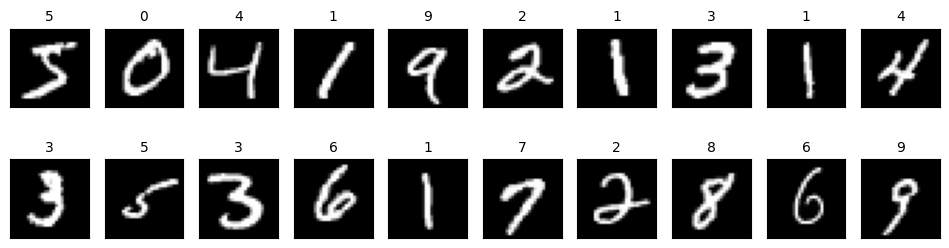

In [4]:
def visualize_images(dataset):
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(12, 3),
                             gridspec_kw={'wspace': 0.2, 'hspace': 0.3})  

    for i, ax in enumerate(axes.flat):
        image, label = dataset[i]
        ax.imshow(image.squeeze(), cmap="gray")
        ax.set_xticks([]), ax.set_yticks([])
        ax.set_title(str(label), fontsize=10)  

    plt.show()

visualize_images(train_dataset)

# Definindo o LightningModule 
talvez tenha q alterar algo aqui, mas tenho que ver

In [5]:
class DataModule(L.LightningDataModule):
    def __init__(self, X_treino, y_treino, X_validacao, y_validacao, X_teste, y_teste, tamanho_lote=128, num_trabalhadores=4):
        super().__init__()
        self.X_treino = X_treino
        self.y_treino = y_treino
        self.X_validacao = X_validacao
        self.y_validacao = y_validacao
        self.X_teste = X_teste
        self.y_teste = y_teste
        self.tamanho_lote = tamanho_lote
        self.num_trabalhadores = num_trabalhadores

    def train_dataloader(self):
        return DataLoader(TensorDataset(self.X_treino, self.y_treino), batch_size=self.tamanho_lote, num_workers=self.num_trabalhadores)

    def val_dataloader(self):
        return DataLoader(TensorDataset(self.X_validacao, self.y_validacao), batch_size=self.tamanho_lote, num_workers=self.num_trabalhadores)

    def test_dataloader(self):
        return DataLoader(TensorDataset(self.X_teste, self.y_teste), batch_size=self.tamanho_lote, num_workers=self.num_trabalhadores)

# Criando a rede

In [6]:
class MLP(L.LightningModule):
    def __init__(self, num_neuronios_por_camada, taxa_aprendizado, dropout_rate, input_size=784, num_classes=10, act_function=nn.ReLU()):
        super().__init__()
        self.save_hyperparameters(ignore=['act_function'])
        
        self.acuracia = torchmetrics.Accuracy(num_classes=num_classes, task='multiclass')
        
        camadas = []
        tamanho_camada = input_size

        for n in num_neuronios_por_camada:
            camadas.extend([nn.Linear(tamanho_camada, n), act_function, nn.Dropout(dropout_rate)])
            tamanho_camada = n
        
        camadas.append(nn.Linear(tamanho_camada, num_classes))
        self.rede = nn.Sequential(*camadas)
        self.fun_perda = nn.CrossEntropyLoss()
        
        self.perdas_treino = []
        self.perdas_val = []
        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []

    def forward(self, x):
        return self.rede(x.view(x.size(0), -1))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y_pred, y)
        acc = self.acuracia(y_pred, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        self.perdas_treino.append(loss)
        self.perdas_val.append(loss)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y_pred, y)
        acc = self.acuracia(y_pred, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.perdas_val.append(loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y_pred, y)
        acc = self.acuracia(y_pred, y)
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        return loss

    def on_train_epoch_end(self):
        perda_media = torch.stack(self.perdas_treino).mean()
        self.curva_aprendizado_treino.append(float(perda_media))
        self.perdas_treino.clear()

    def on_validation_epoch_end(self):
        perda_media = torch.stack(self.perdas_val).mean()
        self.curva_aprendizado_val.append(float(perda_media))
        self.perdas_val.clear()

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.taxa_aprendizado)

In [7]:
dm = DataModule(X_treino, y_treino, X_validacao, y_validacao, X_teste, y_teste)

model = MLP(num_neuronios_por_camada=[84, 56, 28], taxa_aprendizado=1e-3, dropout_rate=0.5, input_size=784, num_classes=10)

trainer = L.Trainer(
    max_epochs=500,
    callbacks=[EarlyStopping(monitor="val_loss", patience=30, mode="min")],
    enable_checkpointing=True,
    deterministic=True
)

trainer.fit(model, dm)

/home/maria23015/anaconda3/envs/pyscf/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/maria23015/anaconda3/envs/pyscf/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name      | Type             

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

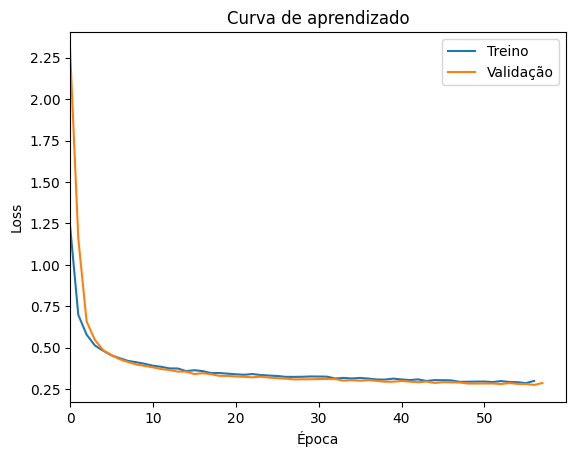

In [8]:
figura, eixo = plt.subplots()

ca_treino = model.curva_aprendizado_treino
ca_val = model.curva_aprendizado_val

eixo.plot(ca_treino, label="Treino")
eixo.plot(ca_val, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss")

# Teste

In [11]:
test_dataset = TensorDataset(X_teste, y_teste)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

trainer.test(model, dataloaders=test_loader)

SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9632999897003174
        test_loss           0.1743084043264389
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.1743084043264389, 'test_acc': 0.9632999897003174}]